# Jonathan Halverson
# Saturday, February 10, 2018
# Home prices in California in Spark 2

In this notebook we perform linear regression and RF on some home prices.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()

In [3]:
housing_raw = spark.read.csv('Sacramentorealestatetransactions.csv', inferSchema=True, header=True)
all_wo_date = housing_raw.columns
all_wo_date.remove('sale_date')
housing_raw.select(all_wo_date).show(5)

+----------------+----------+-----+-----+----+-----+------+-----------+-----+---------+-----------+
|          street|      city|  zip|state|beds|baths|sq__ft|       type|price| latitude|  longitude|
+----------------+----------+-----+-----+----+-----+------+-----------+-----+---------+-----------+
|    3526 HIGH ST|SACRAMENTO|95838|   CA|   2|    1|   836|Residential|59222|38.631913|-121.434879|
|     51 OMAHA CT|SACRAMENTO|95823|   CA|   3|    1|  1167|Residential|68212|38.478902|-121.431028|
|  2796 BRANCH ST|SACRAMENTO|95815|   CA|   2|    1|   796|Residential|68880|38.618305|-121.443839|
|2805 JANETTE WAY|SACRAMENTO|95815|   CA|   2|    1|   852|Residential|69307|38.616835|-121.439146|
| 6001 MCMAHON DR|SACRAMENTO|95824|   CA|   2|    1|   797|Residential|81900| 38.51947|-121.435768|
+----------------+----------+-----+-----+----+-----+------+-----------+-----+---------+-----------+
only showing top 5 rows



In [4]:
housing_raw.toPandas().head(3).T

,0,1,2
street,3526 HIGH ST,51 OMAHA CT,2796 BRANCH ST
city,SACRAMENTO,SACRAMENTO,SACRAMENTO
zip,95838,95823,95815
state,CA,CA,CA
beds,2,3,2
baths,1,1,1
sq__ft,836,1167,796
type,Residential,Residential,Residential
sale_date,Wed May 21 00:00:00 EDT 2008,Wed May 21 00:00:00 EDT 2008,Wed May 21 00:00:00 EDT 2008
price,59222,68212,68880


In [5]:
from pyspark.sql.functions import to_timestamp
housing = housing_raw.withColumn('sale_date', to_timestamp('sale_date', 'EEE MMM d H:mm:ss z yyyy'))

In [6]:
housing.printSchema()

root
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- sq__ft: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- price: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [7]:
housing.groupBy('sale_date').count().show()

+-------------------+-----+
|          sale_date|count|
+-------------------+-----+
|2008-05-19 00:00:00|  268|
|2008-05-21 00:00:00|  158|
|2008-05-15 00:00:00|  118|
|2008-05-16 00:00:00|  264|
|2008-05-20 00:00:00|  177|
+-------------------+-----+



In [8]:
housing.select('beds', 'baths', 'sq__ft', 'price', 'latitude').describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|              beds|             baths|            sq__ft|             price|           latitude|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               985|               985|               985|               985|                985|
|   mean|2.9116751269035532|1.7766497461928934|1314.9167512690356|234144.26395939087| 38.607732086294504|
| stddev|1.3079322320435807|0.8953714223186463| 853.0482425034448|138365.83908492787|0.14543287915296987|
|    min|                 0|                 0|                 0|              1551|          38.241514|
|    max|                 8|                 5|              5822|            884790|          39.020808|
+-------+------------------+------------------+------------------+------------------+-------------------+



In [9]:
housing.count()

985

In [10]:
housing.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sq__ft       985 non-null int64
type         985 non-null object
sale_date    985 non-null datetime64[ns]
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 92.4+ KB


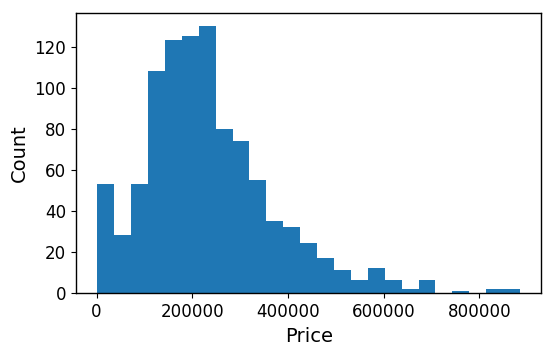

In [11]:
plt.hist(housing.select('price').rdd.map(lambda x: x[0]).collect(), bins=25)
plt.xlabel('Price')
plt.ylabel('Count')

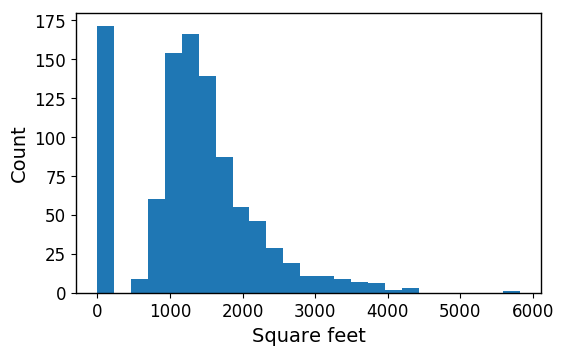

In [12]:
plt.hist(housing.select('sq__ft').rdd.map(lambda x: x[0]).collect(), bins=25)
plt.xlabel('Square feet')
plt.ylabel('Count')

In [13]:
housing.groupBy('baths').count().orderBy('baths').show()

+-----+-----+
|baths|count|
+-----+-----+
|    0|  108|
|    1|  180|
|    2|  544|
|    3|  132|
|    4|   19|
|    5|    2|
+-----+-----+



In [14]:
housing.groupBy('beds').count().orderBy('beds').show()

+----+-----+
|beds|count|
+----+-----+
|   0|  108|
|   1|   10|
|   2|  133|
|   3|  413|
|   4|  258|
|   5|   59|
|   6|    3|
|   8|    1|
+----+-----+



In [15]:
housing.groupBy('type').count().orderBy('type').show()

+------------+-----+
|        type|count|
+------------+-----+
|       Condo|   54|
|Multi-Family|   13|
| Residential|  917|
|      Unkown|    1|
+------------+-----+



In [16]:
from pyspark.sql import functions as F
housing.groupBy('city').agg(F.avg('price'), F.count('*')).orderBy('avg(price)').show(100)

+---------------+------------------+--------+
|           city|        avg(price)|count(1)|
+---------------+------------------+--------+
|    SLOUGHHOUSE|            2000.0|       1|
|        LINCOLN| 96539.26388888889|      72|
|        ELVERTA|          132866.0|       4|
|NORTH HIGHLANDS|135659.33333333334|      21|
|WEST SACRAMENTO|          170700.0|       3|
|      RIO LINDA|172727.61538461538|      13|
| CITRUS HEIGHTS|187114.91428571427|      35|
|     FORESTHILL|          194818.0|       1|
|     SACRAMENTO|197735.98861047835|     439|
|DIAMOND SPRINGS|          216033.0|       1|
|   MEADOW VISTA|          230000.0|       1|
|       ANTELOPE|232496.39393939395|      33|
|           GALT|236943.42857142858|      21|
|         MATHER|          237800.0|       1|
|  POLLOCK PINES|240302.66666666666|       3|
|      EL DORADO|          247000.0|       2|
| RANCHO CORDOVA| 263405.9285714286|      28|
|   CAMERON PARK|267944.44444444444|       9|
|      ELK GROVE| 271157.692982456

# How to combine columns of vectors

In [36]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

vec_idx = StringIndexer(inputCol="type", outputCol="indexed")
model = vec_idx.fit(housing)
td = model.transform(housing)
ohe = OneHotEncoder(inputCol="indexed", outputCol="ohe")
ohe.transform(td).show()

+--------------------+--------------+-----+-----+----+-----+------+-----------+-------------------+------+---------+-----------+-------+-------------+
|              street|          city|  zip|state|beds|baths|sq__ft|       type|          sale_date| price| latitude|  longitude|indexed|          ohe|
+--------------------+--------------+-----+-----+----+-----+------+-----------+-------------------+------+---------+-----------+-------+-------------+
|        3526 HIGH ST|    SACRAMENTO|95838|   CA|   2|    1|   836|Residential|2008-05-21 00:00:00| 59222|38.631913|-121.434879|    0.0|(3,[0],[1.0])|
|         51 OMAHA CT|    SACRAMENTO|95823|   CA|   3|    1|  1167|Residential|2008-05-21 00:00:00| 68212|38.478902|-121.431028|    0.0|(3,[0],[1.0])|
|      2796 BRANCH ST|    SACRAMENTO|95815|   CA|   2|    1|   796|Residential|2008-05-21 00:00:00| 68880|38.618305|-121.443839|    0.0|(3,[0],[1.0])|
|    2805 JANETTE WAY|    SACRAMENTO|95815|   CA|   2|    1|   852|Residential|2008-05-21 00:0

In [26]:
model.transform(housing).select(all_wo_date + ['indexed']).show()

+--------------------+--------------+-----+-----+----+-----+------+-----------+------+---------+-----------+-------+
|              street|          city|  zip|state|beds|baths|sq__ft|       type| price| latitude|  longitude|indexed|
+--------------------+--------------+-----+-----+----+-----+------+-----------+------+---------+-----------+-------+
|        3526 HIGH ST|    SACRAMENTO|95838|   CA|   2|    1|   836|Residential| 59222|38.631913|-121.434879|    0.0|
|         51 OMAHA CT|    SACRAMENTO|95823|   CA|   3|    1|  1167|Residential| 68212|38.478902|-121.431028|    0.0|
|      2796 BRANCH ST|    SACRAMENTO|95815|   CA|   2|    1|   796|Residential| 68880|38.618305|-121.443839|    0.0|
|    2805 JANETTE WAY|    SACRAMENTO|95815|   CA|   2|    1|   852|Residential| 69307|38.616835|-121.439146|    0.0|
|     6001 MCMAHON DR|    SACRAMENTO|95824|   CA|   2|    1|   797|Residential| 81900| 38.51947|-121.435768|    0.0|
|  5828 PEPPERMILL CT|    SACRAMENTO|95841|   CA|   3|    1|  11

In [19]:
housing.groupBy('city').pivot('baths', [0, 1, 2, 3]).avg('price').orderBy('city').show(10)

+---------------+------------------+-----------------+------------------+-----------------+
|           city|                 0|                1|                 2|                3|
+---------------+------------------+-----------------+------------------+-----------------+
|       ANTELOPE|              null|         223139.0|        212704.625|       293041.375|
|         AUBURN|              null|             null|          272500.0|         494818.0|
|   CAMERON PARK|          119000.0|         201000.0|298785.71428571426|             null|
|     CARMICHAEL|              null|         212218.0|          293097.2|         668365.0|
| CITRUS HEIGHTS|              null|147464.2857142857|         195035.28|         192418.0|
|           COOL|              null|             null|          300000.0|             null|
|DIAMOND SPRINGS|              null|             null|          216033.0|             null|
|      EL DORADO|              null|         205000.0|          289000.0|       

In [20]:
housing.where("city == 'SACRAMENTO'").select(all_wo_date).show()

+-------------------+----------+-----+-----+----+-----+------+-----------+------+---------+-----------+
|             street|      city|  zip|state|beds|baths|sq__ft|       type| price| latitude|  longitude|
+-------------------+----------+-----+-----+----+-----+------+-----------+------+---------+-----------+
|       3526 HIGH ST|SACRAMENTO|95838|   CA|   2|    1|   836|Residential| 59222|38.631913|-121.434879|
|        51 OMAHA CT|SACRAMENTO|95823|   CA|   3|    1|  1167|Residential| 68212|38.478902|-121.431028|
|     2796 BRANCH ST|SACRAMENTO|95815|   CA|   2|    1|   796|Residential| 68880|38.618305|-121.443839|
|   2805 JANETTE WAY|SACRAMENTO|95815|   CA|   2|    1|   852|Residential| 69307|38.616835|-121.439146|
|    6001 MCMAHON DR|SACRAMENTO|95824|   CA|   2|    1|   797|Residential| 81900| 38.51947|-121.435768|
| 5828 PEPPERMILL CT|SACRAMENTO|95841|   CA|   3|    1|  1122|      Condo| 89921|38.662595|-121.327813|
|6048 OGDEN NASH WAY|SACRAMENTO|95842|   CA|   3|    2|  1104|Re

In [21]:
housing.groupBy('city').count().orderBy('city').show(50)

+---------------+-----+
|           city|count|
+---------------+-----+
|       ANTELOPE|   33|
|         AUBURN|    5|
|   CAMERON PARK|    9|
|     CARMICHAEL|   20|
| CITRUS HEIGHTS|   35|
|           COOL|    1|
|DIAMOND SPRINGS|    1|
|      EL DORADO|    2|
|EL DORADO HILLS|   23|
|      ELK GROVE|  114|
|        ELVERTA|    4|
|      FAIR OAKS|    9|
|         FOLSOM|   17|
|     FORESTHILL|    1|
|           GALT|   21|
|  GARDEN VALLEY|    1|
|     GOLD RIVER|    4|
|    GRANITE BAY|    3|
|      GREENWOOD|    1|
|        LINCOLN|   72|
|         LOOMIS|    2|
|         MATHER|    1|
|   MEADOW VISTA|    1|
|NORTH HIGHLANDS|   21|
|     ORANGEVALE|   11|
|         PENRYN|    1|
|    PLACERVILLE|   10|
|  POLLOCK PINES|    3|
| RANCHO CORDOVA|   28|
| RANCHO MURIETA|    3|
|      RIO LINDA|   13|
|        ROCKLIN|   17|
|      ROSEVILLE|   48|
|     SACRAMENTO|  439|
|SHINGLE SPRINGS|    1|
|    SLOUGHHOUSE|    1|
|   WALNUT GROVE|    1|
|WEST SACRAMENTO|    3|
|         WILTON

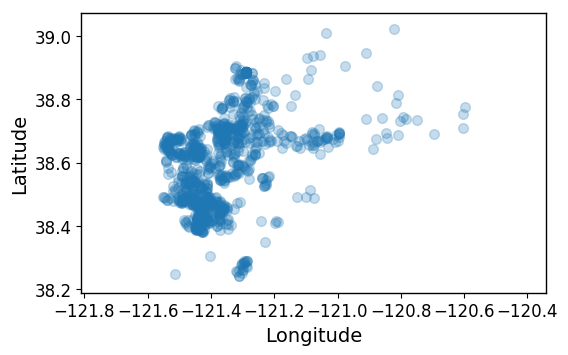

In [22]:
x = housing.select('longitude').rdd.map(lambda row: row[0]).collect()
y = housing.select('latitude').rdd.map(lambda row: row[0]).collect()
plt.scatter(x, y, alpha=0.25)
plt.axis('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [23]:
housing.select('price', 'beds', 'baths', 'sq__ft', 'city').orderBy('price', ascending=True).show(10)

+-----+----+-----+------+-----------+
|price|beds|baths|sq__ft|       city|
+-----+----+-----+------+-----------+
| 1551|   3|    3|     0|    LINCOLN|
| 2000|   3|    4|  5822|SLOUGHHOUSE|
| 4897|   0|    0|     0|    LINCOLN|
| 4897|   0|    0|     0|    LINCOLN|
| 4897|   0|    0|     0|    LINCOLN|
| 4897|   0|    0|     0|    LINCOLN|
| 4897|   0|    0|     0|    LINCOLN|
| 4897|   0|    0|     0|    LINCOLN|
| 4897|   0|    0|     0|    LINCOLN|
| 4897|   0|    0|     0|    LINCOLN|
+-----+----+-----+------+-----------+
only showing top 10 rows



In [24]:
housing.groupBy('price').count().orderBy('count', ascending=False).show()

+------+-----+
| price|count|
+------+-----+
|  4897|   49|
|220000|   10|
|250000|    9|
|150000|    9|
|170000|    9|
|205000|    8|
|195000|    7|
|225000|    7|
|165000|    7|
|230000|    7|
|180000|    7|
|200000|    7|
|215000|    7|
|300000|    7|
|145000|    7|
|315000|    6|
|270000|    6|
|160000|    5|
|190000|    5|
|125000|    5|
+------+-----+
only showing top 20 rows



# Use encoder for cities

We see in the table above that there are zero min values. Let's remove all homes with a zero:

In [25]:
df = df[df.baths > 0]
df = df[df.beds > 0]
df = df[df.sqft > 0]

NameError: name 'df' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [ ]:
pf = df.toPandas()

In [ ]:
plt.plot(pf['sqft'], pf['price'], 'wo')
plt.xlabel('Square feet')
plt.ylabel('Price')

### Machine learning model

In [ ]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint

In [ ]:
df = df.select('price','baths','beds','sqft')
data_features = df.map(lambda x: x[1:])
data_features.take(5)

In [ ]:
from pyspark.mllib.feature import StandardScaler
stdsc = StandardScaler(withMean=False, withStd=True).fit(data_features)
data_features_std = stdsc.transform(data_features)

In [ ]:
from pyspark.mllib.stat import Statistics
data_features_std_stats = Statistics.colStats(data_features_std)
print 'train means:', data_features_std_stats.mean()
print 'train variances:', data_features_std_stats.variance()

In [ ]:
transformed_data = df.map(lambda x: x[0]).zip(data_features_std)
transformed_data = transformed_data.map(lambda x: LabeledPoint(x[0], [x[1]]))
transformed_data.take(5)

Perform a train-test split:

In [ ]:
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
linearModel = LinearRegressionWithSGD.train(train_data, iterations=1000, step=0.25, intercept=False)
print linearModel.weights

Note below that a LabeledPoint has features and label data members:

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
prediObserRDDin = train_data.map(lambda row: (float(linearModel.predict(row.features[0])), row.label))
metrics = RegressionMetrics(prediObserRDDin)
print metrics.r2

In [ ]:
prediObserRDDout = test_data.map(lambda row: (float(linearModel.predict(row.features[0])), row.label))
metrics = RegressionMetrics(prediObserRDDout)
print metrics.rootMeanSquaredError